In [1]:
#!pip install spotpy
import spotpy

# Link BMI_CFE with Spotpy

In [2]:
import os
import sys
#from netCDF4 import Dataset
#from pathlib import Path
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


In [3]:
import bmi_cfe
import cfe

## set up spotpy class

In [4]:
class spotpy_setup(object): 

    def __init__(self): 
        # setup calibration parameters
        self.params = [spotpy.parameter.Uniform('bb',0,21.94,optguess=16),
                       spotpy.parameter.Uniform('smcmax',0.20554,1,optguess=0.439), #maybe max = 0.5
                       spotpy.parameter.Uniform('satdk',0,0.000726,optguess=3.38e-6),
                       spotpy.parameter.Uniform('slop',0,1,optguess=0.01),
                       spotpy.parameter.Uniform('max_gw_storage',0.01,0.25,optguess=0.01),
                       spotpy.parameter.Uniform('expon',1,8,optguess=6.0),
                       spotpy.parameter.Uniform('Cgw',1.8e-6,1.8e-3),
                       spotpy.parameter.Uniform('K_lf',0,0.1),
                       spotpy.parameter.Uniform('K_nash',0,0.1),
                       ]
    
        # Load test comparison data (streamflow) from usgs data
        data = pd.read_csv('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500-usgs-hourly.csv')
        self.obs_data = data['QObs_CAMELS(mm/h)'].values
        self.eval_dates = data['date'].values

        # Initialize the model
        self.cfemodel = bmi_cfe.BMI_CFE('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/cal_test_config_cfe.json')
        print('###--------model succesfully setup----------###')
        self.cfemodel.initialize()
        print('###--------model succesfully initialized----------###')

        with open(self.cfemodel.forcing_file, 'r') as f:
            self.df_forcing = pd.read_csv(f)
        print(f"###----- forcing_file loaded:{self.cfemodel.forcing_file}. -----###")

        # usgs starts earlier, so cutting the forcing data to start on the first date of usgs data
        cal_start_idx = np.where(self.df_forcing['date']==self.eval_dates[0])
        self.df_forcing = self.df_forcing.iloc[cal_start_idx[0][0]:,:]

        # usgs data has nan after around 2014, so limiting entire calibration to 2009. 
        cal_end_idx_usgs = np.where(data['date'].values=='2009-10-01 04:00:00')
        self.eval_dates = self.eval_dates[:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[:cal_end_idx_usgs[0][0]+1]

        cal_end_idx_nldas = np.where(self.df_forcing['date'].values=='2009-10-01 04:00:00')
        self.df_forcing = self.df_forcing.iloc[:cal_end_idx_nldas[0][0]+1,:]
        
        print('###------nldas start date: ' + self.df_forcing['date'].values[0]+ "-----###")
        print('###------nldas end date: ' + self.df_forcing['date'].values[-1]+"-----###")
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###-----after defining start date nldas length: ' +  str(len(self.df_forcing['date'].values))+"------###")
        print('###---------- after defining usgs end date usgs length: ' +  str(len(self.obs_data)) + '.---------')

    def parameters(self):
        return spotpy.parameter.generate(self.params)
        
    def simulation(self,vector):
        self.cfemodel = bmi_cfe.BMI_CFE('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/cal_test_config_cfe.json')
        print('###--------model succesfully setup----------###')
        self.cfemodel.initialize()
        print('###--------model succesfully initialized----------###')

        with open(self.cfemodel.forcing_file, 'r') as f:
            self.df_forcing = pd.read_csv(f)
        print(f"###----- forcing_file loaded:{self.cfemodel.forcing_file}. -----###")

        # usgs starts earlier, so cutting the forcing data to start on the first date of usgs data
        cal_start_idx = np.where(self.df_forcing['date']==self.eval_dates[0])
        self.df_forcing = self.df_forcing.iloc[cal_start_idx[0][0]:,:]

        # usgs data has nan after around 2014, so limiting entire calibration to 2009. 
        cal_end_idx_usgs = np.where(self.eval_dates=='2009-10-01 04:00:00')
        self.eval_dates = self.eval_dates[:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[:cal_end_idx_usgs[0][0]+1]

        cal_end_idx_nldas = np.where(self.df_forcing['date'].values=='2009-10-01 04:00:00')
        self.df_forcing = self.df_forcing.iloc[:cal_end_idx_nldas[0][0]+1,:]
        
        print('###------nldas start date: ' + self.df_forcing['date'].values[0]+ "-----###")
        print('###------nldas end date: ' + self.df_forcing['date'].values[-1]+"-----###")
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###-----after defining start date nldas length: ' +  str(len(self.df_forcing['date'].values))+"------###")
        print('###---------- after defining usgs end date usgs length: ' +  str(len(self.obs_data)) + '.---------')
        
        self.generated_param = vector
        print(f"###----------- parameters generated: {self.generated_param}.--------###")
        self.cfemodel.soil_params['bb']=vector[0]
        self.cfemodel.soil_params['smcmax']=vector[1]
        self.cfemodel.soil_params['satdk']=vector[2]
        self.cfemodel.soil_params['slop']=vector[3]
        self.cfemodel.max_gw_storage==vector[4]
        self.cfemodel.expon=vector[5]
        self.cfemodel.Cgw=vector[6]
        self.cfemodel.K_lf=vector[7]
        self.cfemodel.K_nash=vector[8]

        self.outputs=self.cfemodel.get_output_var_names()
        self.output_lists = {output:[] for output in self.outputs}

        for precip, pet in zip(self.df_forcing['total_precipitation'],self.df_forcing['potential_evaporation']):
            #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
            #sys.exit(1)
            self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
            self.cfemodel.set_value('water_potential_evaporation_flux', pet)
            self.cfemodel.update()
            
        # for precip in self.df_forcing['total_precipitation']:
        #     self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
        #     self.cfemodel.update()
        
            for output in self.outputs:
                self.output_lists[output].append(self.cfemodel.get_value(output))
           
        self.cfemodel.finalize()

        print(f'###----------output length: {len(self.output_lists["land_surface_water__runoff_depth"])}.---------###')

        return self.output_lists['land_surface_water__runoff_depth']

    def evaluation(self,evaldates=False):
        if evaldates:
            self.eval_dates_output = [pd.Timestamp(test.eval_dates[i]) for i in range(len(test.eval_dates))]
            return self.eval_dates_output
        else:
            print(f"###--------- double check - length of obs_data: {len(self.obs_data)}. -----------###")
            print("###--------The streamflow unit from model is m/h, usgs streamflow obs unit is mm/h. --------###")
            return self.obs_data

    def objectivefunction(self,simulation,evaluation, params=None):
        self.obj_function = spotpy.objectivefunctions.kge(evaluation,simulation)
        return self.obj_function

## Evaluate and Plot

In [5]:
test = spotpy_setup()
sampler = spotpy.algorithms.dds(test,dbname='TestDDS',dbformat='csv')

###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2009-10-01 04:00:00-----###
###--------- usgs start date: 1989-10-01 04:00:00.---------
###--------- usgs end date: 2009-10-01 04:00:00.---------
###-----after defining start date nldas length: 175321------###
###---------- after defining usgs end date usgs length: 175321.---------
###--------- double check - length of obs_data: 175321. -----------###
###--------The streamflow unit from model is m/h, usgs streamflow obs unit is mm/h. --------###


In [6]:
sampler.sample(10)

Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  10  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 10 repetitions...
Finding best starting point for trial 1 using 5 random samples.
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500_hourly_nldas.csv. -----###
###------nldas start date: 1989-10-01 04:00:00-----###
###------nldas end date: 2009-10-01 04:00:00-----###
###--------- usgs start date: 1989-10-01 04:00:00.---------
###--------- usgs end date: 2009-10-01 04:00:00.---------
###-----after defining start date nldas length: 175321------###
###---------- after defining usgs end date usgs length: 175321.---------
###----------- parameters generated: parameters(bb=10.7224, smcmax=0.589936, satdk=0.000503964, slop=0.575706, max_gw_storage=0.134233, expon=2.77785, Cgw=0.000157393, K_lf=0.081142

[{'sbest': spotpy.parameter.ParameterSet(),
  'trial_initial': [13.511367998286325,
   0.8911448146761783,
   0.0003278659930183997,
   0.4466074892691978,
   0.15233055360444808,
   2.986399541292092,
   0.00093579878978942,
   0.06353094639748716,
   0.08702433895193552],
  'objfunc_val': -1569.3515426271667}]

In [8]:
results = sampler.getdata()

In [9]:
print(spotpy.analyser.get_best_parameterset(results))

Best parameter set:
bb=13.51, smcmax=0.891, satdk=0.0003278, slop=0.4465, max_gw_storage=0.1523, expon=2.986, Cgw=0.000936, K_lf=0.06354, K_nash=0.08704
[(13.51 , 0.891, 0.0003278, 0.4465, 0.1523, 2.986, 0.000936, 0.06354, 0.08704)
 ( 7.547, 0.891, 0.0003278, 0.722 , 0.1523, 3.934, 0.001208, 0.0363 , 0.079  )
 (13.51 , 0.891, 0.0003278, 0.732 , 0.1812, 5.656, 0.000936, 0.06354, 0.08704)
 (16.11 , 0.891, 0.0003278, 0.4465, 0.1523, 2.986, 0.000936, 0.03784, 0.08704)
 (13.51 , 0.891, 0.0003278, 0.4465, 0.1523, 2.986, 0.000936, 0.06775, 0.08704)]


The figure as been saved as "Parameter_trace.png


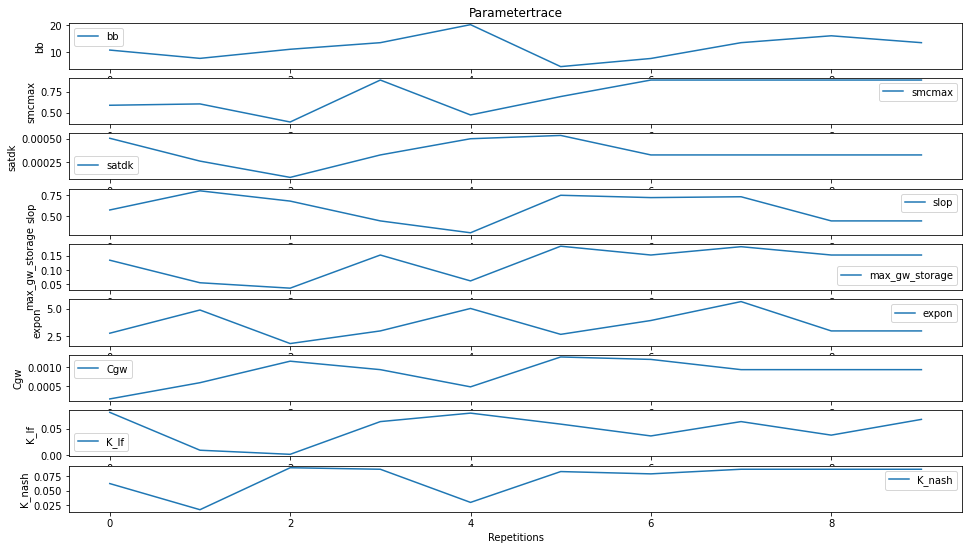

In [10]:
spotpy.analyser.plot_parametertrace(results)

In [11]:
evaluation = test.evaluation()
evaldates= test.evaluation(evaldates=True)

likes=results['like1']

best=np.nanmax(likes)

index=np.where(likes==best)

best_sim = spotpy.analyser.get_modelruns(results[index[0][0]])

best_sim = np.array([best_sim[i] for i in range(len(best_sim))])

###--------- double check - length of obs_data: 175321. -----------###
###--------The streamflow unit from model is m/h, usgs streamflow obs unit is mm/h. --------###


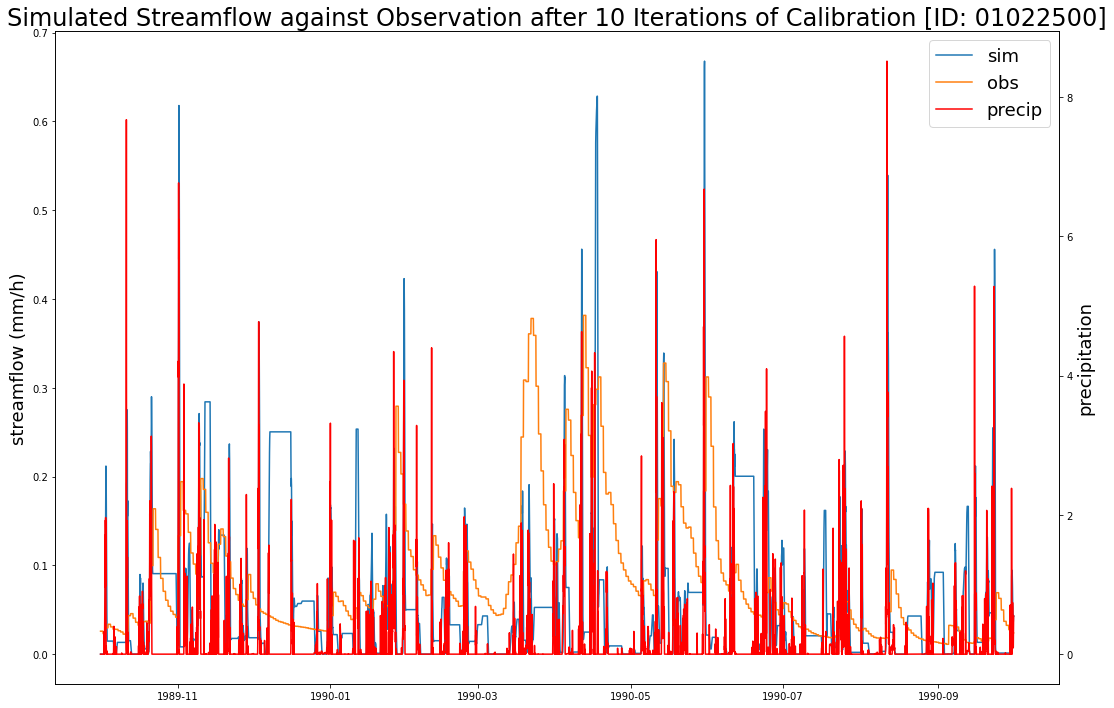

In [17]:
fig, ax1 = plt.subplots(figsize = (18,12)) 
p1, = ax1.plot(evaldates[0:8760],best_sim[0:8760]/1000, label = "sim")
p2, = ax1.plot(evaldates[0:8760],test.obs_data[0:8760],label = "obs")
ax1.set_ylabel('streamflow (mm/h)',fontsize = 18)
ax2 = ax1.twinx()
p3, = ax2.plot(evaldates[0:8760],test.df_forcing["total_precipitation"][0:8760],'r', label = "precip")
ax2.set_ylabel('precipitation',fontsize = 18)
ax2.set_xlabel('Date', fontsize = 18)
plt.legend(handles = [p1,p2,p3],fontsize = 18)
plt.title('Simulated Streamflow against Observation after 10 Iterations of Calibration [ID: 01022500]', fontsize = 24)
plt.show()